# *Machine Learning* em Reanimação Neonatal
Projeto 1 da Disciplina de Aprendizado de Máquina - PPgEEC/UFRN

## Etapa 4 - TRAIN

Neste notebook será realizado o treinamento do algoritmo *Decision Tree* utilizando os artefatos criados na etapa de segregação.

## 1.  Configuração do Ambiente e Leitura de Artefatos

In [45]:
import logging
import wandb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

Login no wandb

In [46]:
!wandb login c4d070b0b80b59891761b50eb9912749a4af585e --relogin

wandb: Appending key for api.wandb.ai to your netrc file: /Users/ericcalasans/.netrc


Variáveis globais

In [47]:
# Tamanho do conjunto de teste(fração do dataset que é utilizada como dados de teste)
val_size = 0.3

# Coeficiente de aleatoriedade
seed = 1618

# Variável alvo(target)
stratify = 'reanimacao'

# Artefato de entrada
input_artifact = 'mlreanimacao/train.csv:latest'

# Tipo do artefato
artifact_type = 'Train'

Configurações de log

In [48]:
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# Objeto logging
logger = logging.getLogger()

Captura de artefato

In [49]:
run = wandb.init(project='mlreanimacao', job_type='train')

# Registra um log desta ação
logger.info("Baixando artefato e realizando leitura...")
artifact = run.use_artifact(input_artifact)
artifact_file = artifact.file()
df_to_split = pd.read_csv(artifact_file)

25-05-2022 21:53:23 Baixando artefato e realizando leitura...


## 3.  Treinamento

Divisão do conjunto de treinamento

In [50]:
logger.info("Divisão em train/val")

x_train, x_val, y_train, y_val = train_test_split(df_to_split.drop(labels=stratify,axis=1),
                                                  df_to_split[stratify],
                                                  test_size=val_size,
                                                  random_state=seed,
                                                  shuffle=True,
                                                  stratify=df_to_split[stratify])

25-05-2022 21:53:26 Divisão em train/val


In [51]:
x_train.sexo

293    Masculino
194    Masculino
182    Masculino
46     Masculino
17     Masculino
         ...    
11      Feminino
243     Feminino
287    Masculino
14      Feminino
72      Feminino
Name: sexo, Length: 267, dtype: object

In [52]:
logger.info("x train: {}".format(x_train.shape))
logger.info("y train: {}".format(y_train.shape))
logger.info("x val: {}".format(x_val.shape))
logger.info("y val: {}".format(y_val.shape))

25-05-2022 21:53:37 x train: (267, 14)
25-05-2022 21:53:37 y train: (267,)
25-05-2022 21:53:37 x val: (115, 14)
25-05-2022 21:53:37 y val: (115,)


### 3.1. Preparação do *Dataset*

Remoção de *outliers* - só tem sentido com dados numéricos.

Será considerada a *feature* **idade_materna** como possível fonte de *outliers* e um *boxplot* da feature revelará se existe outliers a serem tratados.

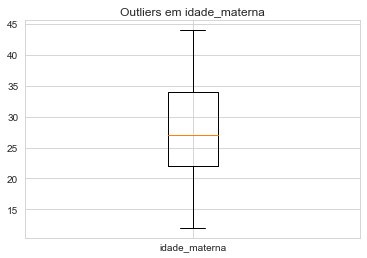

In [53]:
%matplotlib inline
plt.boxplot(df_to_split['idade_materna'])
plt.title('Outliers em idade_materna')
plt.xlabel('idade_materna')
plt.tick_params(
    axis='x',
    bottom=False,
    labelbottom=False
)
plt.show()

A princípio não parece haver *outliers* na *feature* porém será deixada a opção de tratamento para os mesmos em caso de surgirem no *dataset*.

In [54]:
logger.info("Remoção de outliers")

# Variável temporária
x = x_train['idade_materna'].copy()

# Redimensiona variável para adequar ao procedimento - técnica sugerida pela mensagem de erro
x = x.values.reshape(-1, 1)

# Identifica e prevê outliers em um único passo
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

25-05-2022 21:53:56 Remoção de outliers


In [55]:
logger.info("x_train shape [original]: {}".format(x_train.shape))
logger.info("x_train shape [outlier removal]: {}".format(x_train.loc[mask,:].shape))

25-05-2022 21:53:58 x_train shape [original]: (267, 14)
25-05-2022 21:53:58 x_train shape [outlier removal]: (259, 14)


Após execução do passo anterior, percebe-se que o algoritmo considerou a existência de 12 *outliers* e os removeu, reduzindo o tamanho do *dataset*.  Desta forma o conjunto de treinamento será atualizado.

In [56]:
x_train = x_train.loc[mask,:].copy()
y_train = y_train[mask].copy()

In [62]:
x_train

,idade_materna,fumo,alcool,psicoativas,tpp,dpp,oligoamnio,sifilis,hiv,covid_mae,dheg,dm,sexo,apgar_1_minuto
293,30.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino,1.0
194,33.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,s_dm,Masculino,9.0
182,39.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,s_sifilis,n_hiv,s_covid,n_dheg,n_dm,Masculino,6.0
46,25.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,s_dm,Masculino,8.0
17,26.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,s_dheg,n_dm,Masculino,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,34.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,s_dheg,s_dm,Feminino,3.0
243,34.0,n_fumo,n_alcool,d_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Feminino,9.0
287,25.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,s_sifilis,n_hiv,n_covid,s_dheg,n_dm,Masculino,8.0
14,24.0,n_fumo,n_alcool,n_psico,s_tpp,d_dpp,n_oligo,n_sifilis,n_hiv,s_covid,n_dheg,n_dm,Feminino,4.0


### 3.2.  Codificação da Variável *Target*

Neste passo a variável *target* categórica terá seus valores de texto substituídos por uma valor numérico.  Originalmente, no *dataset* recebido da API, as variáveis são já codificadas em valores numéricos pelo operador do sistema de alimentação dos dados via dicionário de dados.  No entanto, este processo foi revertido aqui na etapa de preprocessamento para fins didáticos.

In [63]:
y_train

array([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0])

In [64]:
logger.info("Codificando variável target")
# Objeto codificador
le = LabelEncoder()

# Treinamento e transformação do conjunto de treinamento
y_train = le.fit_transform(y_train)

# Transformação do conjunto de validação - não é necessário treinamento pois já
# foi realizado
y_val = le.transform(y_val)

logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

25-05-2022 21:55:07 Codificando variável target
25-05-2022 21:55:07 Classes [0, 1]: [0 1]


In [65]:
y_val

array([1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0])

### 3.3. Codificação das *Features*

#### 3.3.1. *Features* Categóricas

In [66]:
x_train.shape

(259, 14)

Seleciona as *features* categóricas

In [67]:
colunas = x_train.select_dtypes('object').columns.to_list()
colunas

['fumo',
 'alcool',
 'psicoativas',
 'tpp',
 'dpp',
 'oligoamnio',
 'sifilis',
 'hiv',
 'covid_mae',
 'dheg',
 'dm',
 'sexo']

In [68]:
x_val.fumo.unique()

array(['n_fumo', 'd_fumo', 's_fumo'], dtype=object)

In [69]:
for col in colunas:
    # Cria o objeto OneHotEncoder
    one_hot = OneHotEncoder(sparse=False, drop='first')

    # Treinamento do codificador
    one_hot.fit(x_train[col].values.reshape(-1,1))

    # Criação de novas colunas
    x_train[one_hot.get_feature_names_out()] = one_hot.transform(x_train[col].values.reshape(-1,1))
    x_val[one_hot.get_feature_names_out()] = one_hot.transform(x_val[col].values.reshape(-1,1))

In [70]:
x_train

,idade_materna,fumo,alcool,psicoativas,tpp,dpp,oligoamnio,sifilis,hiv,covid_mae,...,x0_s_sifilis,x0_n_hiv,x0_s_hiv,x0_n_covid,x0_s_covid,x0_n_dheg,x0_s_dheg,x0_n_dm,x0_s_dm,x0_Masculino
293,30.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
194,33.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
182,39.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,s_sifilis,n_hiv,s_covid,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
46,25.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
17,26.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,34.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
243,34.0,n_fumo,n_alcool,d_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
287,25.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,s_sifilis,n_hiv,n_covid,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
14,24.0,n_fumo,n_alcool,n_psico,s_tpp,d_dpp,n_oligo,n_sifilis,n_hiv,s_covid,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [71]:
x_val

,idade_materna,fumo,alcool,psicoativas,tpp,dpp,oligoamnio,sifilis,hiv,covid_mae,...,x0_s_sifilis,x0_n_hiv,x0_s_hiv,x0_n_covid,x0_s_covid,x0_n_dheg,x0_s_dheg,x0_n_dm,x0_s_dm,x0_Masculino
306,35.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,d_hiv,s_covid,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
156,27.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
282,28.0,n_fumo,n_alcool,n_psico,n_tpp,s_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
281,42.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,s_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
334,40.0,n_fumo,n_alcool,n_psico,s_tpp,s_dpp,n_oligo,s_sifilis,n_hiv,n_covid,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,21.0,d_fumo,d_alcool,d_psico,n_tpp,n_dpp,d_oligo,d_sifilis,d_hiv,d_covid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
370,34.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,s_sifilis,n_hiv,n_covid,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
18,15.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
172,35.0,n_fumo,n_alcool,n_psico,n_tpp,s_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0


In [72]:
# Finaliza a execução do wandb
run.finish()